###### Imports

In [124]:
import neurom as nm
import plotly.express as px
import morphio
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
import gudhi as gd 
import pandas as pd
import random
import math
import tmd
import os
import cv2
from tmd.view import plot as tmdplt
from tmd.Topology import analysis
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import plotly.graph_objects as go
import seaborn as sns
from sklearn.manifold import TSNE
from Utilities import *
plt.style.use(['seaborn-white'])

<ipython-input-124-cc5b94da11ee>:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-white'])


###### General variables

In [264]:
morpho_data_path = '../data/morphologies/swc30/'
metadata_data_path = '../data/metadata/'
thresholds_occur_regs = 30
random_state = 1441

###### Loading of metadata

In [3]:
# We load the CSV file containing brain regions into a pandas dataframe
df = pd.read_csv(metadata_data_path + 'morph_regions.csv')
morpho_labels_reg = df.iloc[:,0].to_numpy()
regions_labels = df.iloc[:,1].to_numpy()
regions_dict = {}
for m in range(len(morpho_labels_reg)):
    regions_dict[morpho_labels_reg[m]] = regions_labels[m]

In [4]:
# Load the CSV file containing m_types regions into a pandas dataframe
df = pd.read_csv(metadata_data_path + 'morpho_metadata_raw.csv')
df = df[['neuron_name', 'cell_type']]
morpho_names_tmp = df.iloc[:,0].to_numpy()
morpho_names_m_types = np.asarray([morpho_name + '.swc' for morpho_name in morpho_names_tmp])
m_types = df.iloc[:,1].to_numpy()

# We select only those m_types appearing more than 10 times in the dataset
unique_m_types, counts_m_types = np.unique(m_types, return_counts = True)
m_types_OI = unique_m_types[counts_m_types > 10]

# We look for the indices of the morphologies we are interested in keeping and we store them
idx_morphos_OI = []
for m_type in m_types_OI:
    idx_morphos_OI.append(np.where(m_types == m_type)[0])
idx_morphos_OI = np.concatenate(idx_morphos_OI)

# We built a final dictionary mapping the name of a morphology to its m_type
morpho_names_m_types_OI = morpho_names_m_types[idx_morphos_OI]
m_types_OI_final = m_types[idx_morphos_OI]
m_types_dict = {}
for m in range(len(morpho_names_m_types_OI)):
    m_types_dict[morpho_names_m_types_OI[m]] = m_types_OI_final[m]

###### Loading morphologies

In [5]:
# We now load all the actual morphologies from the .swc files.
# Not all files can be loaded and the regions and m_types are not necessarily in the same order as we load them but we use 
# the dictionaries we built to map them and store these info in the good order
list_morpho = os.listdir(morpho_data_path)
all_morphos = []
all_names = []
all_regs = []
all_m_types = []
for i, tmp_morpho in enumerate(m_types_dict.keys()):
    if tmp_morpho.endswith('.swc'):
        tmp_filename = morpho_data_path + tmp_morpho
        try: 
            all_morphos.append(tmd.io.load_neuron_from_morphio(tmp_filename))
            all_names.append(tmp_morpho)
            all_regs.append(regions_dict[tmp_morpho])
            all_m_types.append(m_types_dict[tmp_morpho])
        except: print('Could not load the file.')
print('%d morphologies were loaded.'%len(all_morphos))
all_morphos = np.asarray(all_morphos)
all_names = np.asarray(all_names)
all_regs = np.asarray(all_regs)
all_m_types = np.asarray(all_m_types)

Could not load the file.
Could not load the file.
Could not load the file.
Could not load the file.
1103 morphologies were loaded.


In [6]:
# All the regions corresponding to the m_type 'granule' are changed to DG (after checking that it is indeed the case)
# If we don't do this this m_type would be discarded since it does not appear in the same exact region more than the threshold 
# impose
for m, m_type in enumerate(np.unique(all_m_types)):
    if m_type.find('granule') != -1:
        id_granule = m
all_regs[all_m_types == np.unique(all_m_types)[id_granule]] = 'DG'

In [7]:
# All the regions corresponding to the m_type 'Purkinje' are changed to Cerebellum (after checking that it is indeed the case)
# If we don't do this this m_type would be discarded since it does not appear in the same exact region more than the threshold 
# impose
for m, m_type in enumerate(np.unique(all_m_types)):
    if m_type.find('Purkinje') != -1:
        id_purkinje = m
all_regs[all_m_types == np.unique(all_m_types)[id_purkinje]] = 'Cerebellum'

###### Getting only the axon neurite

In [8]:
# For each morphology loaded, we select only the axonal part since the focus of our analysis
all_morpho_axons = [morpho.axon[0] for morpho in all_morphos]

###### Selecting only the samples (morphologies) belonging to regions with a certain number of occurencies

In [9]:
unique_regions, counts_regions = np.unique(all_regs, return_counts = True)
regions_desired = unique_regions[counts_regions > thresholds_occur_regs]
print('There are %d regions passing the threshold over the minimal number of occurencies.'%len(regions_desired))
print('There regions are :', regions_desired)

There are 8 regions passing the threshold over the minimal number of occurencies.
There regions are : ['Cerebellum' 'DG' 'MOs2/3' 'MOs5' 'MOs6a' 'PRE' 'SUB' 'VAL']


In [10]:
# We store the indices of the morphologies belonging to the regions of interest identified 
idx_regions_desired = {}
for reg in regions_desired:
    idx_regions_desired[reg] = np.where(np.asarray(all_regs) == reg)[0]

In [11]:
# We rebuild the variables that we want by selecting now only the morphologies belong to the regions OI
morphos_OI = []
regs_OI = []
names_OI = []
m_types_OI = []
for reg in idx_regions_desired.keys():
    morphos_OI.append(np.asarray(all_morpho_axons)[idx_regions_desired[reg]])
    regs_OI.append([reg] * len(idx_regions_desired[reg]))
    names_OI.append(np.asarray(all_names)[idx_regions_desired[reg]])
    m_types_OI.append(np.asarray(all_m_types)[idx_regions_desired[reg]])
morphos_OI = np.asarray(np.concatenate(morphos_OI))
regs_OI = np.asarray(np.concatenate(regs_OI))
names_OI = np.asarray(np.concatenate(names_OI))
m_types_OI = np.asarray(np.concatenate(m_types_OI))
n_morphos = len(morphos_OI)
print('Number of morphos : ', n_morphos)
print('Number of file names : ', len(names_OI))
print('Number of m_types : ', len(m_types_OI))
print('Number of regs : ', len(regs_OI))

Number of morphos :  512
Number of file names :  512
Number of m_types :  512
Number of regs :  512


###### Computing the persistent diagrams

In [12]:
# We compute now the persistent diagrams of the axonal tress of the selected morphologies.
# We do so by computing it both by using the 'radial distance' and the 'path distance' as filtration metrics
all_pd = {'rad' : [], 'path' : []}
for axon_tree in morphos_OI:
    all_pd['rad'].append(tmd.methods.get_persistence_diagram(axon_tree, feature = "radial_distances"))
    all_pd['path'].append(tmd.methods.get_persistence_diagram(axon_tree, feature = "path_distances"))

###### Computing the persistent images

In [14]:
# We compute the persistent images by using the persistent diagrams we already computed. 
# - We are scaling all the persistent images to the same scales (xlims, ylims)
# - We are using as norm_factor 1 in order to NOT normalize for now the persistent images
all_pi = {'rad': [], 'path' : []}
not_computed_idx = []
for metric in all_pd.keys():
    # Computing the xlim and ylim in order to scale all the persistent images accordingly
    xlims, ylims = analysis.get_limits(all_pd[metric])
    for i, tmp_pd in enumerate(all_pd[metric]):
        try: 
            # We set norm factor to 1 because we actually don't want to normalize the persistent images individually
            all_pi[metric].append(analysis.get_persistence_image_data(tmp_pd, xlim = xlims, ylim = ylims, norm_factor = 1))
        except: 
            print('Persistent image has not been computed.')
            not_computed_idx.append(i)
names_OI = np.delete(names_OI, np.unique(not_computed_idx))
m_types_OI = np.delete(m_types_OI, np.unique(not_computed_idx))
regs_OI = np.delete(regs_OI, np.unique(not_computed_idx))
n_morphos = len(names_OI)
print('Now there are %d neurons.'%np.shape(all_pi[metric])[0])
print(len(names_OI))
print(len(m_types_OI))
print(len(regs_OI))

Persistent image has not been computed.
Persistent image has not been computed.
Persistent image has not been computed.
Persistent image has not been computed.
Now there are 510 neurons.
508
508
508


###### Normalization

In [15]:
# To normalize we divide each persistent images by the sum of its values in the picture (this makes each image a sort of 
# probabilistic map). Then we multiply them per the number of branches there were in the diagram (in order to take into account 
# the differences in the number of branches).
all_pi_norm = {}
for metric in all_pi.keys():
    all_pi_norm[metric] = []
    for im in range(len(all_pi[metric])):
        n_branches = len(all_pd[metric][im])
        all_pi_norm[metric].append(n_branches * all_pi[metric][im]/np.sum(all_pi[metric][im]))
    all_pi_norm[metric] = np.asarray(all_pi_norm[metric])

In [ ]:
# save_variable(all_pi_norm, '../Results/Saved_variables/all_persistent_images_normalized')

In [ ]:
# #### TO CHECK (NOT SURE)
# # This is just to plot the persistent images all on the same scale and also normalized as explained above
# for metric in all_pd.keys():
#     # Computing the xlim and ylim in order to scale all the persistent images accordingly
#     xlims, ylims = analysis.get_limits(all_pd[metric])
#     for i, tmp_pd in enumerate(all_pd[metric]):
#         n_branches = len(tmp_pd)
#         norm_fact = np.sum(all_pi[metric][im])/n_branches
#         vmax = np.max(all_pi[metric][im]/norm_fact)
# #         tmp , _ = tmdplt.persistence_image(tmp_pd, xlim = xlims, ylim = ylims, vmin = 0, vmax = 1, norm_factor = norm_fact)
#         try: 
#             tmp , _ = tmdplt.persistence_image(tmp_pd, xlim = xlims, ylim = ylims, vmin = 0, vmax = vmax, norm_factor = norm_fact)
#             plt.savefig('../Results/Persistent_images/Scaled_images/%s/%s.png'%(metric, names_OI[i].split('.')[0]), bbox_inches = 'tight')
#         except: 
#             print('Persistent image has not been computed.')

###### Merging the subregions of MO and make them all 'MO'

In [16]:
merged_regs = []
for reg in regs_OI:
    if reg[:2] == 'MO': merged_regs.append('MO')
    else: merged_regs.append(reg)
merged_regs = np.asarray(merged_regs)
print('The new (merged) regions are:')
for i in np.unique(merged_regs):
    print('- %s'%i)

The new (merged) regions are:
- Cerebellum
- DG
- MO
- PRE
- SUB
- VAL


###### Restructuring data

In [17]:
# We flatten the persistent images in order to have a final matrix having shape N x F, where N = number of samples (neurons) and
# F = number of features
flatten_pi = {}
for metric in all_pi_norm.keys():
    tmp_data = all_pi_norm[metric]
    n_samples = np.shape(tmp_data)[0]
    flatten_pi[metric] = np.reshape(tmp_data, (n_samples, -1))

###### Applying dimensionality reduction (tSNE)

In [18]:
data_embedded = {}
for metric in flatten_pi.keys():
    tmp_data = flatten_pi[metric]
    data_embedded[metric] = TSNE(n_components = 2, perplexity = np.round(np.sqrt(n_morphos)), random_state = random_state).fit_transform(tmp_data)

In [270]:
save_variable(data_embedded, '../Results/Saved_variables/data_embedded_TSNE_n2_random_state%d'%random_state)

###### We build a labels vector for different types of labels


In [20]:
# Original regions of interested (not merged MO layers)
labels_regs = np.unique(regs_OI)
idx_labels_regs = {}
for label in labels_regs:
    idx_labels_regs[label] = np.where(regs_OI == label)[0]

# Merged regions labels
labels_merged_regs = np.unique(merged_regs)
idx_labels_merged_regs = {}
for label in labels_merged_regs:
    idx_labels_merged_regs[label] = np.where(merged_regs == label)[0]

# M-types layers
labels_m_types = np.unique(m_types_OI)
idx_labels_m_types = {}
for label in labels_m_types:
    idx_labels_m_types[label] = np.where(m_types_OI == label)[0]

###### Plotting t-SNE visualization following different labels or metrics

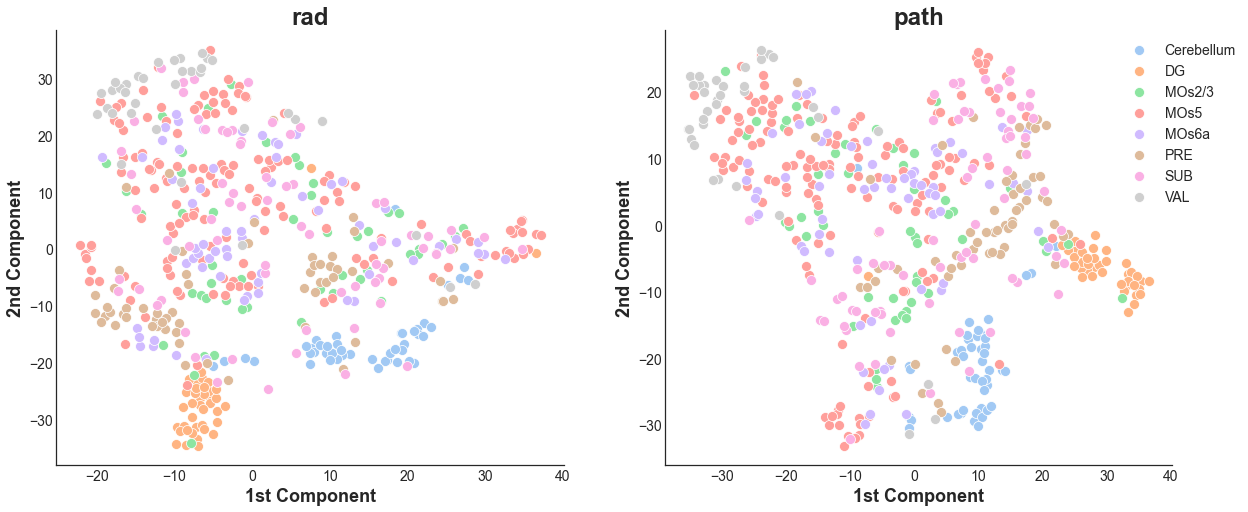

In [166]:
curr_labels = idx_labels_regs
plt.figure(figsize = (20, 8))
sns.set_palette("pastel")
for m, metric in enumerate(data_embedded.keys()):
    tmp_embedded_data = data_embedded[metric]
    all_data = []
    plt.subplot(1,2,m+1)
    for lab in curr_labels.keys():
        x = tmp_embedded_data[curr_labels[lab],0]
        y = tmp_embedded_data[curr_labels[lab],1]
        if m == 1: sns.scatterplot(x,y, label = lab, s = 100)
        else: sns.scatterplot(x,y,s = 100)
    if m == 1: plt.legend(fontsize = 14, bbox_to_anchor = (1.15,1))
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('1st Component', fontsize = 18, weight = 'bold')
    plt.ylabel('2nd Component', fontsize = 18, weight = 'bold')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(metric, weight = 'bold', fontsize = 24)
plt.savefig('../Results/Figures/TSNE_proj_n2_regs.png', dpi = 300, bbox_inches = 'tight')
plt.show()

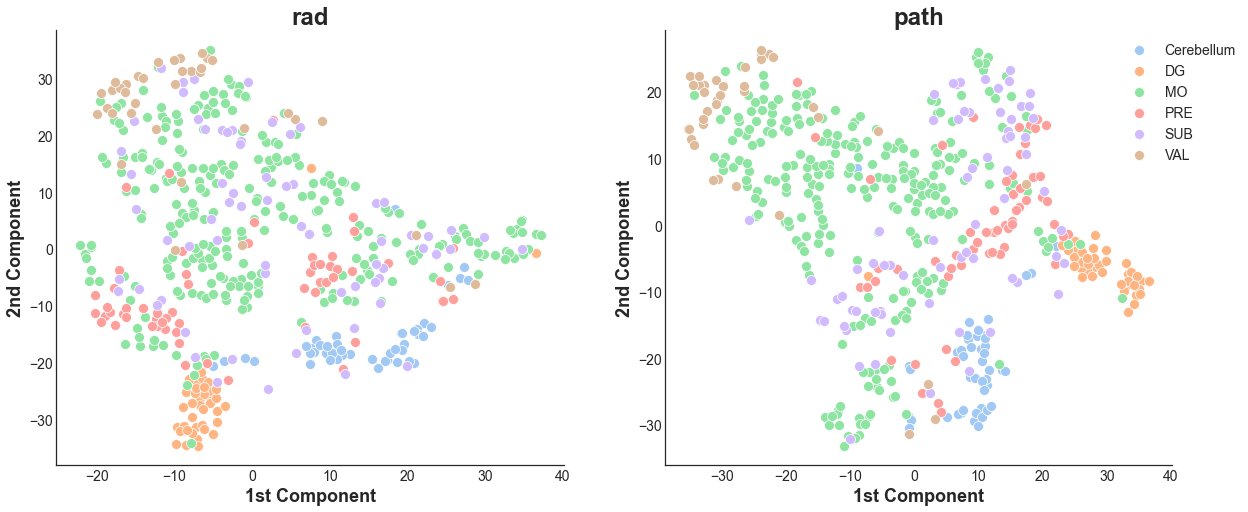

In [167]:
curr_labels = idx_labels_merged_regs
plt.figure(figsize = (20, 8))
sns.set_palette("pastel")
for m, metric in enumerate(data_embedded.keys()):
    tmp_embedded_data = data_embedded[metric]
    all_data = []
    plt.subplot(1,2,m+1)
    for lab in curr_labels.keys():
        x = tmp_embedded_data[curr_labels[lab],0]
        y = tmp_embedded_data[curr_labels[lab],1]
        if m == 1: sns.scatterplot(x,y, label = lab, s = 100)
        else: sns.scatterplot(x,y,s = 100)
    if m == 1: plt.legend(fontsize = 14, bbox_to_anchor = (1.15,1))
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('1st Component', fontsize = 18, weight = 'bold')
    plt.ylabel('2nd Component', fontsize = 18, weight = 'bold')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(metric, weight = 'bold', fontsize = 24)
plt.savefig('../Results/Figures/TSNE_proj_n2_merged_regs.png', dpi = 300, bbox_inches = 'tight')
plt.show()

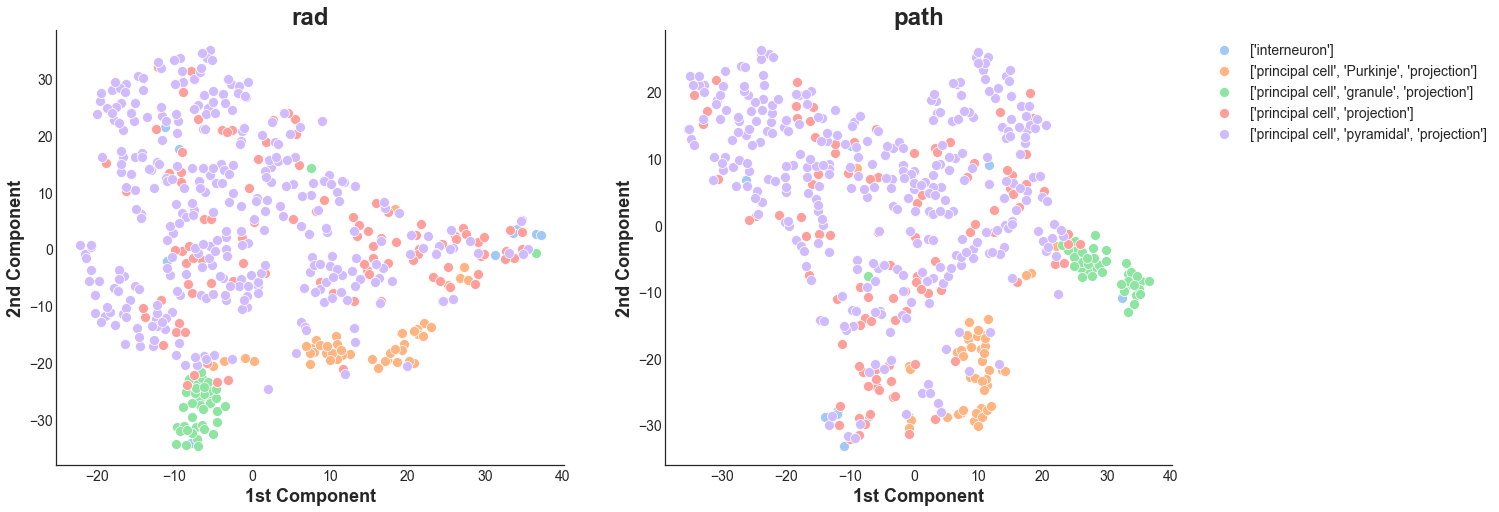

In [168]:
curr_labels = idx_labels_m_types 
plt.figure(figsize = (20, 8))
sns.set_palette("pastel")
for m, metric in enumerate(data_embedded.keys()):
    tmp_embedded_data = data_embedded[metric]
    all_data = []
    plt.subplot(1,2,m+1)
    for lab in curr_labels.keys():
        x = tmp_embedded_data[curr_labels[lab],0]
        y = tmp_embedded_data[curr_labels[lab],1]
        if m == 1: sns.scatterplot(x,y, label = lab, s = 100)
        else: sns.scatterplot(x,y,s = 100)
    if m == 1: plt.legend(fontsize = 14, bbox_to_anchor = (1.05,1))
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('1st Component', fontsize = 18, weight = 'bold')
    plt.ylabel('2nd Component', fontsize = 18, weight = 'bold')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(metric, weight = 'bold', fontsize = 24)
plt.savefig('../Results/Figures/TSNE_proj_n2_mtypes.png', dpi = 300, bbox_inches = 'tight')
plt.show()

###### Now selecting only the neurons belonging to the m_type pyramidal or projection

In [217]:
# We select the two classes of m_types that we see overlap a lot in the projection using t-SNE 
mt1 = "['principal cell', 'projection']"
mt2 = "['principal cell', 'pyramidal', 'projection']"

idx1 = np.where(m_types_OI == mt1)[0]
idx2 = np.where(m_types_OI == mt2)[0]
all_idx_OI = np.concatenate([idx1, idx2])
sel_names = names_OI[all_idx_OI]
n_sel_morphos = len(all_idx_OI)
print('There are %s selected morphos.'%n_sel_morphos)

There are 415 selected morphos.


In [170]:
data_embedded_sel = {}
for metric in data_embedded.keys():
    data_embedded_sel[metric] = data_embedded[metric][all_idx_OI, :]

In [171]:
save_variable(data_embedded_sel, '../Results/Saved_variables/data_embedded_selected_morphos_TSNE_n2_random_state%d'%random_state)

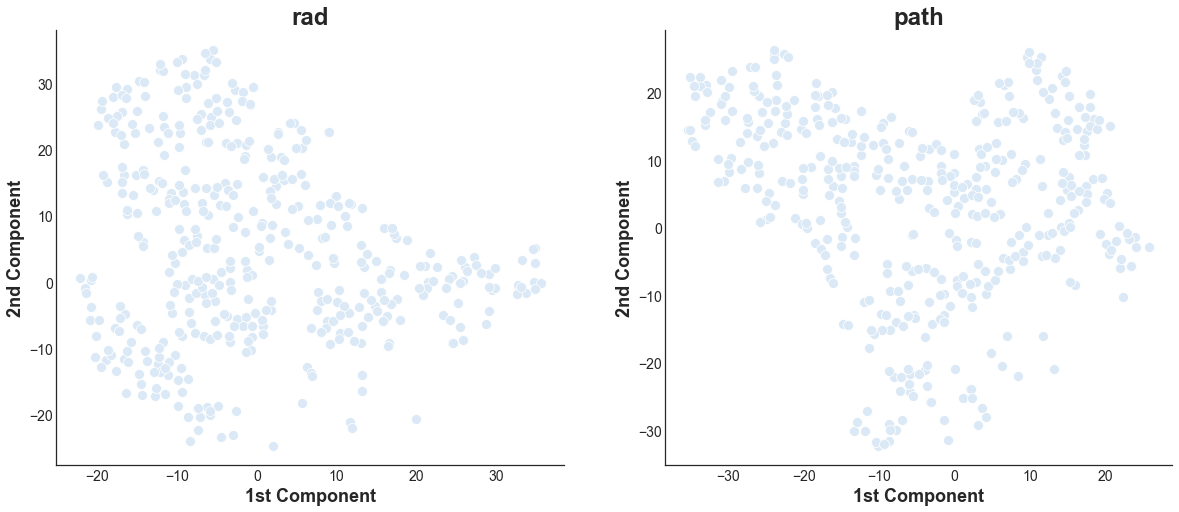

In [177]:
curr_labels = idx_labels_m_types 
plt.figure(figsize = (20, 8))
sns.set_palette("Blues")
for m, metric in enumerate(data_embedded_sel.keys()):
    tmp_embedded_data = data_embedded_sel[metric]
    all_data = []
    plt.subplot(1,2,m+1)
    x = tmp_embedded_data[:,0]
    y = tmp_embedded_data[:,1]
    sns.scatterplot(x,y,s = 100)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('1st Component', fontsize = 18, weight = 'bold')
    plt.ylabel('2nd Component', fontsize = 18, weight = 'bold')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(metric, weight = 'bold', fontsize = 24)
plt.savefig('../Results/Figures/TSNE_proj_n2_selected_morphos.png', dpi = 300, bbox_inches = 'tight')
plt.show()

###### Trying to cluster the projected morphos using  K-means

In [255]:
# We try to optimize the number of clusters using the elbow method 
# Also, because of randomness present in K-means initialization, we repeat the procedure 10 times and we plot only the average of
# the sse values  (Sum of Squared Errors)
k_values = range(1, 11)  # Possible number of clusters
all_sse = {}
for metric in data_embedded_sel.keys():
    all_sse[metric] = []
    for rep in range(20):
        tmp_data = data_embedded_sel[metric]
        sse = []
        for k in k_values:
            kmeans = KMeans(n_clusters = k, n_init = 'auto')
            kmeans.fit(tmp_data)
            sse.append(kmeans.inertia_)
        all_sse[metric].append(sse)
    all_sse[metric] = np.asarray(all_sse[metric])

In [256]:
# Computing mean and std over the 20 repetitions
sse_mean_rad = np.mean(all_sse['rad'], axis = 0)
sse_std_rad = np.std(all_sse['rad'], axis = 0)
sse_mean_path = np.mean(all_sse['path'], axis = 0)
sse_std_path = np.std(all_sse['path'], axis = 0)

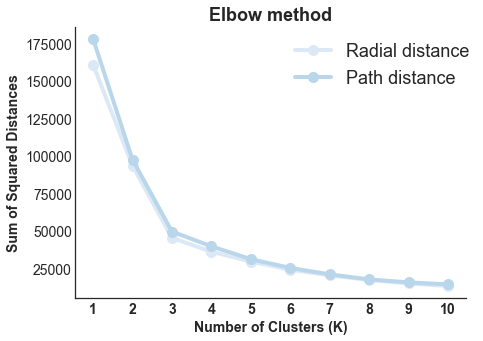

In [259]:
plt.figure(figsize = (7,5))
# RADIAL
plt.plot(k_values, sse_mean_rad, ls = '-', lw = 4, marker = '.', ms = 20, label = 'Radial distance')
plt.plot(k_values, sse_mean_path, ls = '-', lw = 4, marker = '.', ms = 20, label = 'Path distance')
plt.xlabel('Number of Clusters (K)', fontsize = 14, weight = 'bold')
plt.ylabel('Sum of Squared Distances', fontsize = 14, weight = 'bold')
plt.title('Elbow method', fontsize = 18, weight = 'bold')
plt.xticks(k_values, fontsize = 14, weight = 'bold')
plt.yticks(fontsize = 14)
plt.legend(fontsize = 18, bbox_to_anchor = (1.05,1))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../Results/Figures/Elbow_method_opt_kmeans.png', dpi = 300, bbox_inches = 'tight')
plt.show()

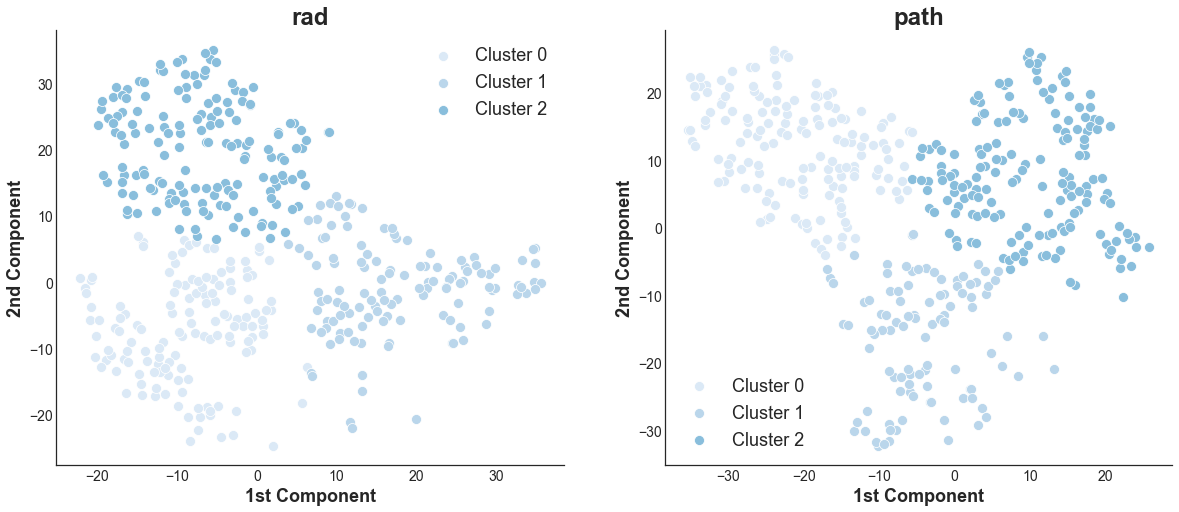

In [227]:
k = 3
plt.figure(figsize = (20, 8))
sns.set_palette("Blues")
for m, metric in enumerate(data_embedded_sel.keys()):
    plt.subplot(1,2,m+1)
    kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = random_state).fit(data_embedded_sel[metric])
    labels = kmeans.labels_
    for l in np.unique(labels):
        x = data_embedded_sel[metric][labels == l,0]
        y = data_embedded_sel[metric][labels == l,1]
        sns.scatterplot(x,y, s = 100, label = 'Cluster %d'%l)
        plt.legend(fontsize = 18)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.xlabel('1st Component', fontsize = 18, weight = 'bold')
        plt.ylabel('2nd Component', fontsize = 18, weight = 'bold')
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title(metric, weight = 'bold', fontsize = 24)
plt.savefig('../Results/Figures/Cluster_kmeans.png', dpi = 300, bbox_inches = 'tight')
plt.show()

###### Trying the clustering via Gaussia Mixture Models

In [261]:
# We try to optimize the number of clusters for GMM using the Silhouette Score
k_values = range(2, 11)  # Possible number of clusters
silhouette_scores = {}
for metric in data_embedded_sel.keys():
    silhouette_scores[metric] = []
    for rep in range(20):
        tmp_data = data_embedded_sel[metric]
        scores = []
        for k in k_values:
            gmm = GaussianMixture(n_components=k)
            labels = gmm.fit_predict(tmp_data)
            scores.append(silhouette_score(tmp_data, labels))
        silhouette_scores[metric].append(scores)
    silhouette_scores[metric] = np.asarray(silhouette_scores[metric])

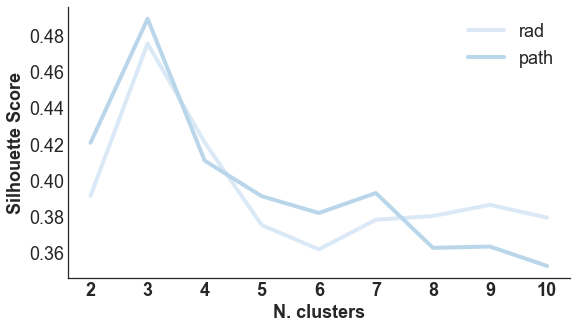

In [262]:
plt.figure(figsize = (9,5))
for metric in silhouette_scores.keys():
    plt.plot(k_values, np.mean(silhouette_scores[metric], axis = 0), lw = 4, label = metric)
plt.legend(fontsize = 18)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize = 18, weight = 'bold')
plt.yticks(fontsize = 18)
plt.xlabel('N. clusters', fontsize = 18, weight = 'bold')
plt.ylabel('Silhouette Score', fontsize = 18, weight = 'bold')
plt.savefig('../Results/Figures/Silhouette_GMMs.png', dpi = 300, bbox_inches = 'tight')
plt.show()

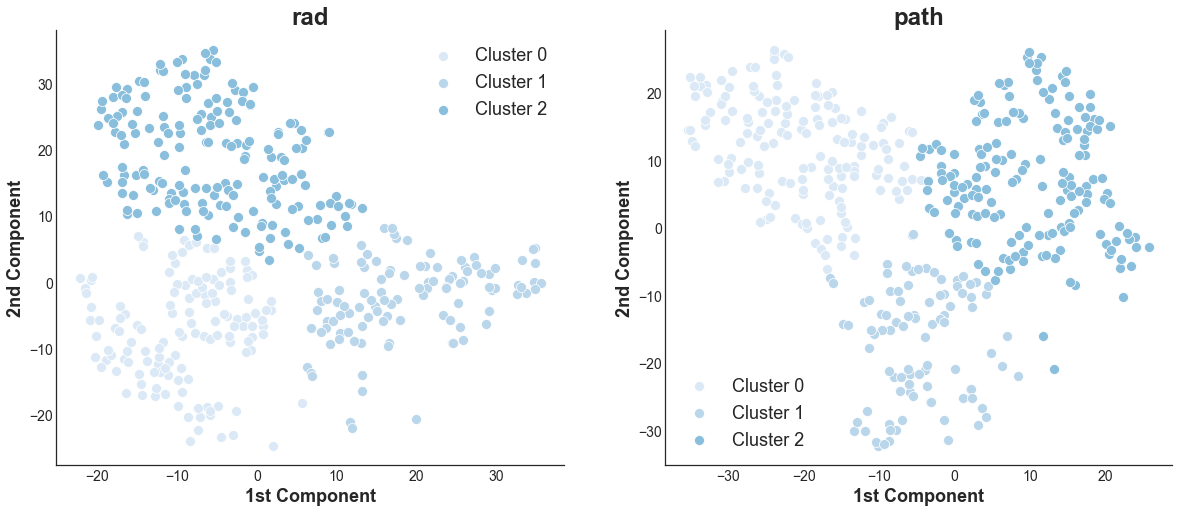

In [230]:
k = 3
plt.figure(figsize = (20, 8))
sns.set_palette("Blues")
for m, metric in enumerate(data_embedded_sel.keys()):
    plt.subplot(1,2,m+1)
    gmm = GaussianMixture(n_components=k, random_state = random_state)
    labels = gmm.fit_predict(data_embedded_sel[metric])
    for l in np.unique(labels):
        x = data_embedded_sel[metric][labels == l,0]
        y = data_embedded_sel[metric][labels == l,1]
        sns.scatterplot(x,y, s = 100, label = 'Cluster %d'%l)
        plt.legend(fontsize = 18)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.xlabel('1st Component', fontsize = 18, weight = 'bold')
        plt.ylabel('2nd Component', fontsize = 18, weight = 'bold')
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title(metric, weight = 'bold', fontsize = 24)
plt.savefig('../Results/Figures/Cluster_GMMs.png', dpi = 300, bbox_inches = 'tight')
plt.show()

###### Computing how much the clusters found using Path Distance and Radial Distance overlap (K-Means)

In [265]:
k = 3
kmeans_rad = KMeans(n_clusters = k, n_init = 'auto', random_state = random_state).fit(data_embedded_sel['rad'])
labels_kmeans_rad = kmeans_rad.labels_
kmeans_path = KMeans(n_clusters = k, n_init = 'auto', random_state = random_state).fit(data_embedded_sel['path'])
labels_kmeans_path = kmeans_path.labels_

In [266]:
sets_rad = {}
for lab in np.unique(labels_kmeans_rad):
    sets_rad[lab] = set(np.where(labels_kmeans_rad == lab)[0])
sets_path = {}
for lab in np.unique(labels_kmeans_path):
    sets_path[lab] = set(np.where(labels_kmeans_path == lab)[0])

In [267]:
vals_intersec = []
for set1 in sets_rad.keys():
    for set2 in sets_path.keys():
        inter = sets_rad[set1].intersection(sets_path[set2])
        vals_intersec.append(100* len(inter)/len(sets_rad[set1]))
vals_intersec = np.asarray(vals_intersec)
vals_intersec = np.reshape(vals_intersec, (k,k))

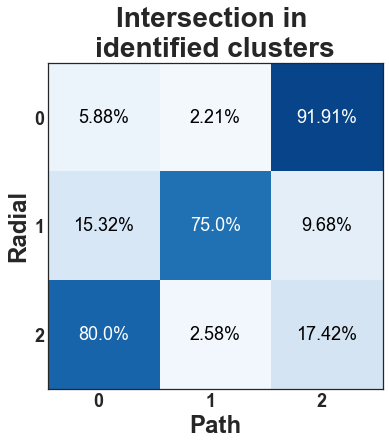

In [268]:
plt.figure(figsize = (6,6))
plt.imshow(vals_intersec, aspect = 'auto', cmap = 'Blues', vmin = 0, vmax = 100)

# Labels
ax = plt.gca()
ax.set_xticks(np.arange(k))
ax.set_yticks(np.arange(k))
ax.set_xticklabels(range(k), fontsize = 18, weight = 'bold')
ax.set_yticklabels(range(k), fontsize = 18, weight = 'bold')
plt.setp(ax.get_xticklabels(), ha = 'right', rotation_mode = 'anchor')
plt.ylabel('Radial', fontsize = 24, weight = 'bold')
plt.xlabel('Path', fontsize = 24, weight = 'bold')

# Loop over data dimensions and create text annotations to show the percentage of percentage of predictions for each combination
for i in range(k):
    for j in range(k):
        if vals_intersec[i, j] > 50:
            text = ax.text(j, i, str(round(vals_intersec[i, j],2)) + '%', ha = 'center', va = 'center', color = 'white', fontsize = 18)
        if vals_intersec[i, j] < 50:
            text = ax.text(j, i, str(round(vals_intersec[i, j],2)) + '%', ha = 'center', va = 'center', color = 'black', fontsize = 18)

plt.title('Intersection in \nidentified clusters', fontsize = 28, weight = 'bold')         
plt.savefig('../Results/Figures/Perce_intersec_clusters_kmeans.png', dpi = 300, bbox_inches = 'tight')
plt.show()

###### Computing how much the clusters found using Path Distance and Radial Distance overlap (GMMs)

In [236]:
k = 3
gmm = GaussianMixture(n_components = k, random_state = random_state)
labels_gmm_rad = gmm.fit_predict(data_embedded_sel['rad'])
gmm = GaussianMixture(n_components = k, random_state = random_state)
labels_gmm_path = gmm.fit_predict(data_embedded_sel['path'])

In [237]:
sets_rad = {}
for lab in np.unique(labels_gmm_rad):
    sets_rad[lab] = set(np.where(labels_gmm_rad == lab)[0])
sets_path = {}
for lab in np.unique(labels_gmm_path):
    sets_path[lab] = set(np.where(labels_gmm_path == lab)[0])

In [238]:
vals_intersec = []
for set1 in sets_rad.keys():
    for set2 in sets_path.keys():
        inter = sets_rad[set1].intersection(sets_path[set2])
        vals_intersec.append(100* len(inter)/len(sets_rad[set1]))
vals_intersec = np.asarray(vals_intersec)
vals_intersec = np.reshape(vals_intersec, (k,k))

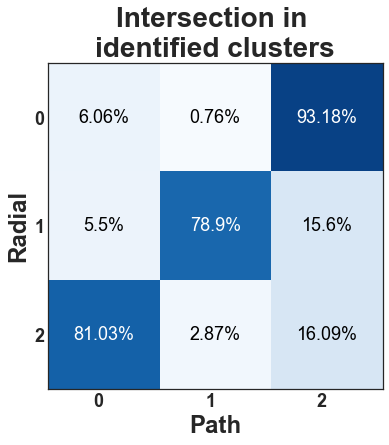

In [239]:
plt.figure(figsize = (6,6))
plt.imshow(vals_intersec, aspect = 'auto', cmap = 'Blues', vmin = 0, vmax = 100)

# Labels
ax = plt.gca()
ax.set_xticks(np.arange(k))
ax.set_yticks(np.arange(k))
ax.set_xticklabels(range(k), fontsize = 18, weight = 'bold')
ax.set_yticklabels(range(k), fontsize = 18, weight = 'bold')
plt.setp(ax.get_xticklabels(), ha = 'right', rotation_mode = 'anchor')
plt.ylabel('Radial', fontsize = 24, weight = 'bold')
plt.xlabel('Path', fontsize = 24, weight = 'bold')

# Loop over data dimensions and create text annotations to show the percentage of percentage of predictions for each combination
for i in range(k):
    for j in range(k):
        if vals_intersec[i, j] > 50:
            text = ax.text(j, i, str(round(vals_intersec[i, j],2)) + '%', ha = 'center', va = 'center', color = 'white', fontsize = 18)
        if vals_intersec[i, j] < 50:
            text = ax.text(j, i, str(round(vals_intersec[i, j],2)) + '%', ha = 'center', va = 'center', color = 'black', fontsize = 18)

plt.title('Intersection in \nidentified clusters', fontsize = 28, weight = 'bold')         
plt.savefig('../Results/Figures/Perce_intersec_clusters_gmms.png', dpi = 300, bbox_inches = 'tight')
plt.show()

###### Saving in pickle dictionaries the names of the morphos that belong to the different clusters
- per metric (radial and path distances)
- per clustering method (Kmeans and GMM)

In [247]:
# K-MEANS
names_kmeans_rad = {}
for l in np.unique(labels_kmeans_rad):
    names_kmeans_rad[l] = sel_names[labels_kmeans_rad == l]
save_variable(names_kmeans_rad, '../Results/Saved_variables/Cluster_dict_names_morphos_kmeans_rad')

names_kmeans_path = {}
for l in np.unique(labels_kmeans_path):
    names_kmeans_path[l] = sel_names[labels_kmeans_path == l]
save_variable(names_kmeans_path, '../Results/Saved_variables/Cluster_dict_names_morphos_kmeans_path')

In [248]:
# GMM
names_gmm_rad = {}
for l in np.unique(labels_gmm_rad):
    names_gmm_rad[l] = sel_names[labels_gmm_rad == l]
save_variable(names_gmm_rad, '../Results/Saved_variables/Cluster_dict_names_morphos_gmms_rad')

names_gmm_path = {}
for l in np.unique(labels_gmm_path):
    names_gmm_path[l] = sel_names[labels_gmm_path == l]
save_variable(names_gmm_path, '../Results/Saved_variables/Cluster_dict_names_morphos_gmms_path')

###### How to reload these variables if needed

In [251]:
tmp_dict = load_pickle_variable('../Results/Saved_variables/Cluster_dict_names_morphos_gmms_rad')
print(tmp_dict)

{0: array(['AA0672.swc', 'AA0793.swc', 'AA0625.swc', 'AA0116.swc',
       'AA0880.swc', 'AA0656.swc', 'AA0422.swc', 'AA0300.swc',
       'AA0668.swc', 'AA0115.swc', 'AA0784.swc', 'AA0109.swc',
       'AA0553.swc', 'AA0159.swc', 'AA0259.swc', 'AA0700.swc',
       'AA0246.swc', 'AA0249.swc', 'AA1058.swc', 'AA0689.swc',
       'AA0495.swc', 'AA0499.swc', 'AA0886.swc', 'AA0885.swc',
       'AA0161.swc', 'AA0847.swc', 'AA0718.swc', 'AA0416.swc',
       'AA0666.swc', 'AA0475.swc', 'AA0637.swc', 'AA0897.swc',
       'AA0738.swc', 'AA0803.swc', 'AA0446.swc', 'AA0916.swc',
       'AA0474.swc', 'AA0587.swc', 'AA0846.swc', 'AA0108.swc',
       'AA0785.swc', 'AA0271.swc', 'AA0898.swc', 'AA0169.swc',
       'AA0415.swc', 'AA0332.swc', 'AA0853.swc', 'AA0289.swc',
       'AA0650.swc', 'AA0889.swc', 'AA0887.swc', 'AA0787.swc',
       'AA0798.swc', 'AA1544.swc', 'AA0913.swc', 'AA0466.swc',
       'AA0906.swc', 'AA0599.swc', 'AA0899.swc', 'AA0064.swc',
       'AA0554.swc', 'AA0767.swc', 'AA0184.swc', 'A